In [1]:
# uniform

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8641975308641975, Loss: 0.5703226372047707
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.569347099021629
Checkpoint 300, Accuracy: 0.8518518518518519, Loss: 0.5656666932282625
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5757923832646122
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5714411912141023


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8844865 ]
 [0.05715739]
 [0.05835602]]
[1. 0. 0.] <-> [[0.80996317]
 [0.126184  ]
 [0.06385279]]
[1. 0. 0.] <-> [[0.46699283]
 [0.28981754]
 [0.24318965]]
[0. 1. 0.] <-> [[0.3399162 ]
 [0.3656576 ]
 [0.29442626]]
[1. 0. 0.] <-> [[0.832903  ]
 [0.11051106]
 [0.05658583]]
[1. 0. 0.] <-> [[0.84896713]
 [0.09815807]
 [0.05287476]]
[1. 0. 0.] <-> [[0.8862986 ]
 [0.04983516]
 [0.06386621]]
[0. 1. 0.] <-> [[0.805815  ]
 [0.12884417]
 [0.06534088]]
[1. 0. 0.] <-> [[0.8136992 ]
 [0.12374828]
 [0.06255252]]
[1. 0. 0.] <-> [[0.8666869 ]
 [0.08206714]
 [0.05124595]]
[1. 0. 0.] <-> [[0.48531762]
 [0.28075624]
 [0.23392609]]
[1. 0. 0.] <-> [[0.83580333]
 [0.10838506]
 [0.05581164]]
[1. 0. 0.] <-> [[0.8514053 ]
 [0.09613641]
 [0.05245819]]
[1. 0. 0.] <-> [[0.88027304]
 [0.06533672]
 [0.05439019]]
[1. 0. 0.] <-> [[0.41968077]
 [0.31618127]
 [0.26413798]]
[1. 0. 0.] <-> [[0.879339  ]
 [0.06678006]
 [0.05388093]]
[1. 0. 0.] <-> [[0.88534385]
 [0.04228442]
 [0.07237172]]
[1. 0. 0.] <->

In [12]:
# Testing Performance

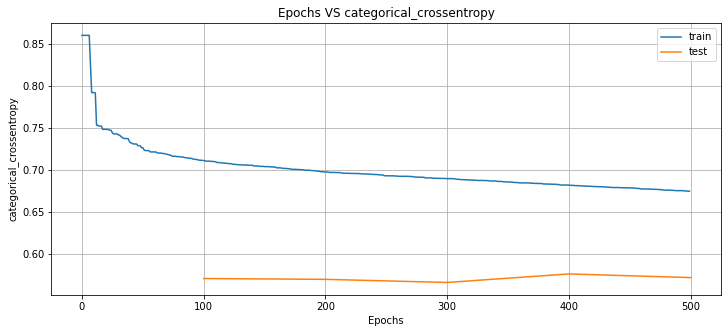

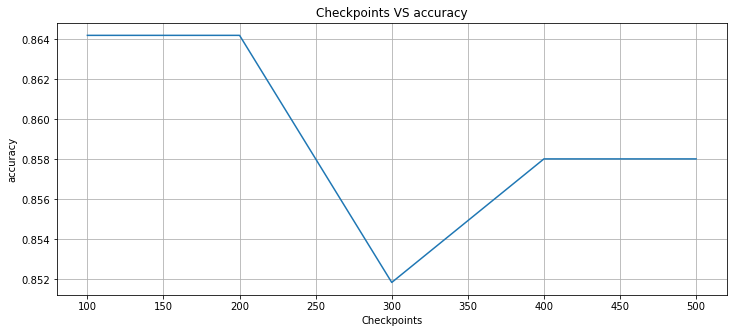

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8641975308641975, 'mean_square_error': 2.7497406211267306, 'categorical_crossentropy': 0.5703226372047707, 'precision': 0.7962962962962963, 'recall': 0.7962962962962963, 'f1': 0.7962962962962963, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 1, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 9, 'fp_hit': 8, 'tn_hit': 87, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 2.791463971195563, 'categorical_crossentropy': 0.569347099021629, 'precision': 0.7962962962962963, 'recall': 0.7962962962962963, 'f1': 0.7962962962962963, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 1, 'fp_hit': 4, 'tn_hit': 89, 'fn_hit': 14}, 2: {'tp_hit': 9, 'fp_hit': 6, 'tn_hit': 89, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 2.8164386908106755, 'categorical_crossentropy': 0.5656666932282625, 'precision': 0

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[[ 2.5766416 ]
 [-0.40239894]
 [-1.2348398 ]
 [-1.7314355 ]
 [ 1.6928215 ]]
 bias: [1.6427623]

Neuron 1: weights:
[[0.8315616 ]
 [0.08141638]
 [0.964312  ]
 [0.359895  ]
 [1.0213017 ]]
 bias: [-0.4080927]

Neuron 2: weights:
[[ 2.5579765 ]
 [-0.382127  ]
 [-1.8415742 ]
 [ 1.3249416 ]
 [ 0.93732005]]
 bias: [-1.0486451]

Neuron 3: weights:
[[-0.37686828]
 [ 0.57992005]
 [ 2.2871418 ]
 [-2.9133034 ]
 [ 1.362966  ]]
 bias: [-1.4889349]

$
Layer 2
Neuron 0: weights:
[[ 0.35746658]
 [-1.1480757 ]
 [ 1.1642803 ]
 [-2.8023486 ]]
 bias: [2.2421029]

Neuron 1: weights:
[[2.064246  ]
 [0.22266479]
 [0.41175604]
 [1.2576286 ]]
 bias: [-1.5910567]

Neuron 2: weights:
[[-2.0808527]
 [ 2.5902307]
 [-1.2748653]
 [ 2.9931655]]
 bias: [0.5669672]

$

